# Explore QM9 Dataset

In [1]:
import torch
import sys
sys.path.append('src')

from torch_geometric.datasets import QM9

ds = QM9(root="../data")

## Load Dataset

In [2]:
# Load raw dataset
ds = QM9(root="../data")
datapoint = ds[5]

print("Raw QM9 Data Structure:")
print(f"Data: {datapoint}")
print(f"\nNode features (x): {datapoint.x.shape}")
print(f"Edge index: {datapoint.edge_index.shape}")
print(f"Edge attributes: {datapoint.edge_attr.shape if hasattr(datapoint, 'edge_attr') and datapoint.edge_attr is not None else 'None'}")
print(f"Positions (pos): {datapoint.pos.shape}")
print(f"Target (y): {datapoint.y.shape}")
print(f"\nFirst molecule:")
print(f"Number of atoms: {datapoint.x.shape[0]}")
print(f"Number of edges: {datapoint.edge_index.shape[1]//2}")

Raw QM9 Data Structure:
Data: Data(x=[4, 11], edge_index=[2, 6], edge_attr=[6, 4], y=[1, 19], pos=[4, 3], z=[4], smiles='[H]C([H])=O', name='gdb_6', idx=[1])

Node features (x): torch.Size([4, 11])
Edge index: torch.Size([2, 6])
Edge attributes: torch.Size([6, 4])
Positions (pos): torch.Size([4, 3])
Target (y): torch.Size([1, 19])

First molecule:
Number of atoms: 4
Number of edges: 3


### We first look at the node features of the dataset

The data consists of 11 features per atom:
- One-hot encoding for atom types: H, C, N, O, F (5 features)
- Atomic number (1 feature)
- Aromaticity (1 feature)
- Hybridization states: sp, sp2, sp3 (3 features)
- Number of bonded hydrogens (1 feature)

In [3]:
import pandas as pd
x = datapoint.x.numpy()

columns = ["H","C","N","O","F","atomic_number","aromatic","sp","sp2","sp3","num_hydrogens"]
xdf = pd.DataFrame(x, columns=columns)
xdf

,H,C,N,O,F,atomic_number,aromatic,sp,sp2,sp3,num_hydrogens
0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,2.0
1,0.0,0.0,0.0,1.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


We see that the this molecule has 4 atoms: 1 carbon, 2 hydrogens and 1 oxygen. 

The carbon and oxygen have sp2 hybridization. 

There is 2 hydrogens bonded to the carbon and 0 bonded to the oxygen.

### QM9 Aromaticity and Hybridization didn't load correctly

The torch QM9 dataloader had a bug where the aromaticity and hybridization features were not loaded correctly with RDKit. 

This resulted in all zeros for all molecules. 

We fixed this so we could use these features in our model. (By sanitizing the molecule but only with respect to aromaticity and hybridization)

### Edge Index

The edge index defines the connectivity between atoms in the molecule, represented as a 2 x num_edges tensor. 

Each column indicates a directed edge from one atom to another.

In [4]:
# read edge index data
edge_index_data = datapoint.edge_index.numpy()
print(f"\nEdge Index Data:\n{edge_index_data}")

# read as connections between atoms
connections = []
num_edges = edge_index_data.shape[1]
for i in range(num_edges):
    src = edge_index_data[0, i]
    dst = edge_index_data[1, i]
    connections.append((src, dst))
print(f"\nAtom Connections (source -> destination):")
for conn in connections:
    print(f"{conn[0]} -> {conn[1]}")


Edge Index Data:
[[0 0 0 1 2 3]
 [1 2 3 0 0 0]]

Atom Connections (source -> destination):
0 -> 1
0 -> 2
0 -> 3
1 -> 0
2 -> 0
3 -> 0


Here we see the specific connections between atoms in the molecule. 

Each pair is a directed edge from one atom to another, but since bonds are undirected, each bond is represented by two directed edges (one in each direction).

### Edge Attributes

The edge attributes provide additional information about each bond in the molecule. Columns is the bond type encoded as one-hot vectors:
- Single bond
- Double bond
- Triple bond
- Aromatic bond

In [5]:
# read edge attributes data
edge_attr_data = datapoint.edge_attr.numpy().astype(int)
edge_attr_df = pd.DataFrame(edge_attr_data, columns=["single_bond","double_bond","triple_bond","aromatic_bond"])
edge_attr_df

,single_bond,double_bond,triple_bond,aromatic_bond
0,0,1,0,0
1,1,0,0,0
2,1,0,0,0
3,0,1,0,0
4,1,0,0,0
5,1,0,0,0


Since bonds are undirected we can look at the first half of the edge attributes to see the bond types between atoms.

We see that the first bond is a double bond and the rest are single bonds.

This means there is a double bond between atom 0 (carbon) and atom 1 (oxygen).

### Targets

For our project target 2 was chosen: predicting the homo energy of molecules.

In [6]:
datapoint.y[0][2]

tensor(-7.2654)

The other targets are as follows

In [7]:
# Add target to header
target_names = ["Dipole moment", "Isotropic polarizability", "HOMO energy", "LUMO energy", "HOMO-LUMO gap", "Electronic spatial extent", "Zero-point vibrational energy", 
                "Internal energy at 0 K", "Internal energy at 298 K", "Enthalpy", "Free energy", "Heat capacity", "Atomization energy at 0 K", "Atomization energy at 298 K", 
                "Atomization enthalpy", "Atomization free energy", "Rotational constant A", "Rotational constant B", "Rotational constant C"]
target_df = pd.DataFrame(datapoint.y.reshape(1, -1), columns=target_names).T
target_df.columns = ["value"]
target_df

,value
Dipole moment,2.108900
Isotropic polarizability,14.180000
HOMO energy,-7.265440
LUMO energy,-1.104782
HOMO-LUMO gap,6.157937
Electronic spatial extent,59.989101
Zero-point vibrational energy,0.723904
Internal energy at 0 K,-3115.257812
Internal energy at 298 K,-3115.179688
Enthalpy,-3115.154053


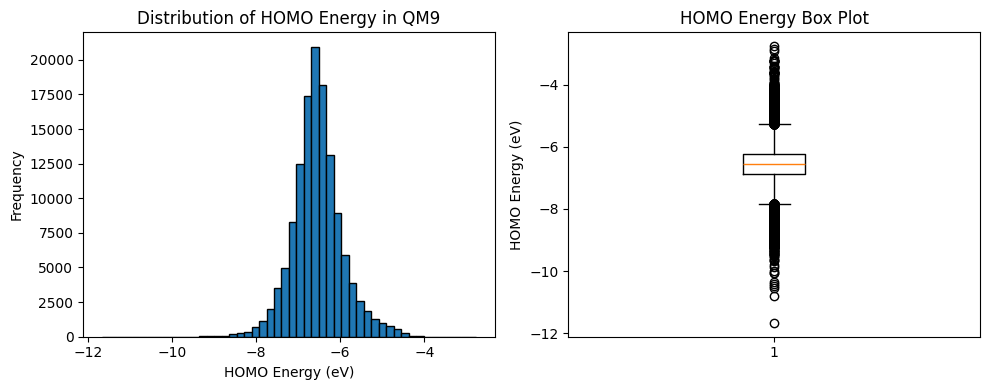

Mean HOMO: -6.536 eV
Std HOMO: 0.598 eV
Min HOMO: -11.663 eV
Max HOMO: -2.767 eV


In [8]:
from matplotlib import pyplot as plt
import numpy as np

# Analyze target distribution
y_values = [data.y[0][2].item() for data in ds]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(y_values, bins=50, edgecolor='black')
plt.xlabel('HOMO Energy (eV)')
plt.ylabel('Frequency')
plt.title('Distribution of HOMO Energy in QM9')

plt.subplot(1, 2, 2)
plt.boxplot(y_values)
plt.ylabel('HOMO Energy (eV)')
plt.title('HOMO Energy Box Plot')
plt.tight_layout()
plt.show()

print(f"Mean HOMO: {np.mean(y_values):.3f} eV")
print(f"Std HOMO: {np.std(y_values):.3f} eV")
print(f"Min HOMO: {np.min(y_values):.3f} eV")
print(f"Max HOMO: {np.max(y_values):.3f} eV")

# Pubchem database (This part is not used for training)

We can search up the smiles of this molecule to get the name

In [9]:
import pubchempy as pcp
res = pcp.get_compounds(datapoint.smiles, namespace='smiles')
res[0].iupac_name
res[0].molecular_formula
res[0].iupac_name, res[0].molecular_formula, res[0].synonyms[:5]

('formaldehyde',
 'CH2O',
 ['formaldehyde', 'formalin', 'methanal', '50-00-0', 'formol'])

We see that this molecule is formaldehyde (methanal) with the formula CH2O.

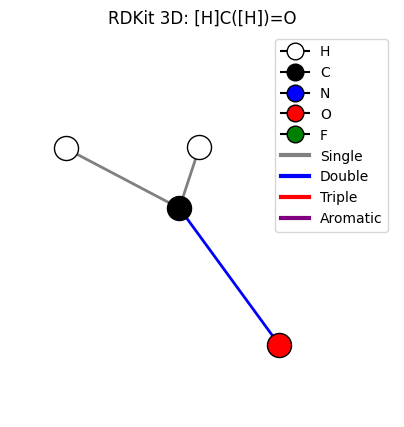

In [10]:
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

def plot_rdkit_3d(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)

    conf = mol.GetConformer()
    coords = np.array([list(conf.GetAtomPosition(i)) for i in range(mol.GetNumAtoms())])

    # Atom colors
    atom_colors = {
        1: 'white',   # H
        6: 'black',   # C
        7: 'blue',    # N
        8: 'red',     # O
        9: 'green'    # F
    }

    # Bond colors by type
    bond_colors = {
        Chem.rdchem.BondType.SINGLE: "gray",
        Chem.rdchem.BondType.DOUBLE: "blue",
        Chem.rdchem.BondType.TRIPLE: "red",
        Chem.rdchem.BondType.AROMATIC: "purple",
    }

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot atoms
    for i, atom in enumerate(mol.GetAtoms()):
        a = atom.GetAtomicNum()
        x, y, z = coords[i]
        ax.scatter(x, y, z, color=atom_colors.get(a, 'yellow'), s=300, edgecolors='k')

    # Plot bonds
    for bond in mol.GetBonds():
        a = bond.GetBeginAtomIdx()
        b = bond.GetEndAtomIdx()

        xs = [coords[a][0], coords[b][0]]
        ys = [coords[a][1], coords[b][1]]
        zs = [coords[a][2], coords[b][2]]

        btype = bond.GetBondType()
        color = bond_colors.get(btype, "black")

        ax.plot(xs, ys, zs, color=color, linewidth=2)

    ax.set_box_aspect([1, 1, 1])
    ax.set_axis_off()
    plt.title(f"RDKit 3D: {smiles}")

    # ---- Atom legend (scatter points) ----
    atom_legend = atom_legend = [
        Line2D([0], [0], marker='o', color='black', markerfacecolor=atom_colors[1], markersize=12, markeredgecolor='black', label="H"),
        Line2D([0], [0], marker='o', color='black', markerfacecolor=atom_colors[6], markersize=12, markeredgecolor='black', label="C"),
        Line2D([0], [0], marker='o', color='black', markerfacecolor=atom_colors[7], markersize=12, markeredgecolor='black', label="N"),
        Line2D([0], [0], marker='o', color='black', markerfacecolor=atom_colors[8], markersize=12, markeredgecolor='black', label="O"),
        Line2D([0], [0], marker='o', color='black', markerfacecolor=atom_colors[9], markersize=12, markeredgecolor='black', label="F"),
    ]

    # ---- Bond legend (lines) ----
    bond_legend = [
        Line2D([0], [0], color="gray", linewidth=3, label="Single"),
        Line2D([0], [0], color="blue", linewidth=3, label="Double"),
        Line2D([0], [0], color="red", linewidth=3, label="Triple"),
        Line2D([0], [0], color="purple", linewidth=3, label="Aromatic"),
    ]

    # Combine both legends
    full_legend = atom_legend + bond_legend

    plt.legend(handles=full_legend)

    plt.show()

# Example:
plot_rdkit_3d(datapoint.smiles)

We can plot it to see the molecule

# Training

Now that we have explored the dataset, we can move on to training our GNN model.

From the EDA above, we have identified the key features of the molecules in the QM9 dataset.

We will remove atomic number from the node features as it is redundant given the one-hot encoding of atom types.

We will use both node features and edge attributes in our GNN model to capture the structural and chemical properties of the molecules.

In [11]:
import sys
import torch

# If your src folder is one level up from the notebook
if "src" not in sys.path:
    sys.path.append("src")

from utils import seed_everything
from trainer import SemiSupervisedEnsemble

In [12]:
seed_everything(seed=0, force_deterministic=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

To remove the atomic_number feature from the node features, we use the RemoveAtomicNumber transform.

This is done in the QM9DataModule

In [13]:
from torch_geometric.data import Data
from torch_geometric.transforms import BaseTransform

class RemoveAtomicNumber(BaseTransform):
    """Remove atomic_number column (column 5) from node features."""
    
    def forward(self, data: Data) -> Data:
        if data.x is not None:
            # Keep columns 0-4 (H,C,N,O,F one-hot) and 6-10 (aromatic, sp, sp2, sp3, num_hydrogens)
            data.x = torch.cat([data.x[:, :5], data.x[:, 6:]], dim=1)
        return data

## Data splits

In [14]:
# Instantiate datamodule
from qm9 import QM9DataModule

dm = QM9DataModule(
    target=2,
    data_dir="../data",
    batch_size_train=128,
    batch_size_inference=512,
    num_workers=0,
    splits=[0.72, 0.08, 0.10, 0.10],  # unlabeled, labeled, val, test
    seed=0,
    pin_memory=False,
    persistent_workers=False,
)

# Access splits
train_unlabeled = dm.data_train_unlabeled
train_labeled   = dm.data_train_labeled
val_ds          = dm.data_val
test_ds         = dm.data_test

print("\nQM9 Split Sizes")
print(f"Total dataset:  {len(train_labeled) + len(train_unlabeled) + len(val_ds) + len(test_ds)}")
print(f"Unlabeled train: {len(train_unlabeled)}")
print(f"Labeled train:   {len(train_labeled)}")
print(f"Validation:      {len(val_ds)}")
print(f"Test:            {len(test_ds)}")

QM9 dataset loaded with 10466 labeled, 94198 unlabeled, 13083 validation, and 13084 test samples.
Batch sizes: labeled=128, unlabeled=128

QM9 Split Sizes
Total dataset:  130831
Unlabeled train: 94198
Labeled train:   10466
Validation:      13083
Test:            13084


We can check that the transform worked

In [15]:
import pandas as pd
print(train_labeled[0].x.shape) # Should be (num_atoms, 10), because we remove the atomic_number feature
pd.DataFrame(train_labeled[0].x.numpy().astype(int), columns=["H","C","N","O","F","aromatic","sp","sp2","sp3","num_hydrogens"]).head()

torch.Size([19, 10])


,H,C,N,O,F,aromatic,sp,sp2,sp3,num_hydrogens
0,0,1,0,0,0,0,0,0,1,3
1,0,1,0,0,0,0,0,0,1,1
2,0,1,0,0,0,0,0,1,0,1
3,0,1,0,0,0,0,0,1,0,1
4,0,1,0,0,0,0,0,0,1,1


## Baseline model

In [16]:
from torch_geometric.nn import GCNConv, global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels=64):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.linear = torch.nn.Linear(hidden_channels, 1)
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.linear(x)

        return x

## Model Selection

We explored different model architectures, including:

- GCNs with varying numbers of layers and hidden channels

- GINEs with varying numbers of layers and hidden channels

We selected **GINE with 5 layers and 64 hidden channels**
- This performed the best on the validation set and makes effective use of edge attributes without overfitting

## Hyperparameters

The different hyperparameters tried for training were as follows:
- Model: GINE5 (edge attributes and 5 layers)
- Optimizer: **AdamW (Best)**, Adam, SGD
    - Learning rates tested: 0.005, 0.001, **0.0005 (Best)**
    - Weight decay tested: **0.005 (Best)**, 0.001, 0.0005
- Unsupervised weight: 1.0
- Mean Teacher: Enabled with EMA decay 0.999

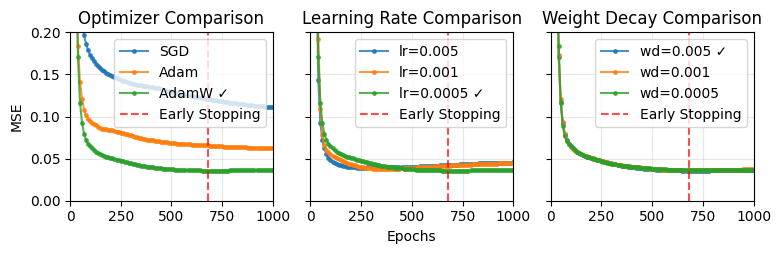

These are all trained with semi-supervised learning

## The final model

This model uses GINE convolutions which are edge-aware and utilize a shared MLP for message passing.

It consists of five GINEConv layers followed by a global mean pooling and a final linear layer for prediction.

In [17]:
import torch
from torch_geometric.nn import GINEConv, global_mean_pool
import torch.nn.functional as F

class GINE5(torch.nn.Module):
    def __init__(self, num_node_features, edge_dim=4, hidden_channels=64):
        super().__init__()

        # Shared MLP used by GINEConv
        def mlp():
            return torch.nn.Sequential(
                torch.nn.Linear(hidden_channels, hidden_channels),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_channels, hidden_channels),
            )

        # First layer: project node features to hidden size
        self.lin_in = torch.nn.Linear(num_node_features, hidden_channels)

        # GINEConv layers (edge aware)
        self.conv1 = GINEConv(mlp(), edge_dim=edge_dim)
        self.conv2 = GINEConv(mlp(), edge_dim=edge_dim)
        self.conv3 = GINEConv(mlp(), edge_dim=edge_dim)
        self.conv4 = GINEConv(mlp(), edge_dim=edge_dim)
        self.conv5 = GINEConv(mlp(), edge_dim=edge_dim)

        # Final readout layer
        self.linear = torch.nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = (
            data.x, data.edge_index, data.edge_attr, data.batch
        )

        # Project input features
        x = self.lin_in(x)
        x = F.relu(x)

        # Edge-aware conv layers
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = F.relu(self.conv3(x, edge_index, edge_attr))
        x = F.relu(self.conv4(x, edge_index, edge_attr))
        x = F.relu(self.conv5(x, edge_index, edge_attr))

        # Pool graph representation
        x = global_mean_pool(x, batch)

        # Layer norm
        x = F.layer_norm(x, x.size()[1:])

        # Dropout
        x = F.dropout(x, p=0.3, training=self.training)

        # Output
        return self.linear(x)

In [18]:
model = GINE5(num_node_features=10, hidden_channels=64).to(device)
model

GINE5(
  (lin_in): Linear(in_features=10, out_features=64, bias=True)
  (conv1): GINEConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  ))
  (conv2): GINEConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  ))
  (conv3): GINEConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  ))
  (conv4): GINEConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  ))
  (conv5): GINEConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  ))
  (linear): Linear(in_features=64, out_features=1,

In [23]:
# Number of parameters
print("\nModel Architecture Summary:")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Number of parameters for each part
lin_in_params = sum(p.numel() for name, p in model.named_parameters() if 'lin_in' in name)
print(f"Parameters in input Linear layer: {lin_in_params:,}")
conv_params = sum(p.numel() for name, p in model.named_parameters() if 'conv' in name)
print(f"Parameters in GINEConv layers: {conv_params:,}")
linear_params = sum(p.numel() for name, p in model.named_parameters() if 'linear' in name)
print(f"Parameters in final Linear layer: {linear_params:,}")


Model Architecture Summary:
Total Parameters: 43,969
Parameters in input Linear layer: 704
Parameters in GINEConv layers: 43,200
Parameters in final Linear layer: 65


## Training the supervised model

For the supervised model, the loss function used is Mean Squared Error (MSE) between the predicted and true target values for the labeled data.
$$
L_{\text{sup}} = \|f(x)-y\|^2,
$$

Where:
- $L_{sup}$ is the supervised loss
- $f(x)$ is the model's prediction
- $y$ is the true target value
- $\|\cdot\|^2$ denotes the squared Euclidean error between predictions and target values.

In [24]:
class DummyLogger:
    def log_dict(self, d, step=None):
        print(d)

logger = DummyLogger()

In [25]:
import torch
import torch.optim as optim

# Same as trainer.init.optimizer in YAML
def make_optimizer(params):
    return optim.AdamW(params, lr=0.0005, weight_decay=0.005)

# Same as trainer.init.scheduler in YAML
def make_scheduler(optimizer):
    return torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.95)

In [26]:
from torch.nn import MSELoss

model = GINE5(num_node_features=10, hidden_channels=64).to(device) # We only have 10 features because we remove the atomic_number feature
models = [model]

trainer = SemiSupervisedEnsemble(
    supervised_criterion=MSELoss(),
    optimizer=make_optimizer,
    scheduler=make_scheduler,
    device=device,
    models=models,
    logger=logger,
    datamodule=dm,
    unsupervised_weight=0.0,
    use_mean_teacher=False,
    ema_decay=0.999,
)

supervised_epochs = 10 # For demonstration, we use a small number of epochs
validation_interval = 5

trainer.train(total_epochs=supervised_epochs, validation_interval=validation_interval)

supervised_test_metrics = trainer.test()
supervised_test_metrics

Using device: cpu


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:05<00:48,  5.43s/it]

{'supervised_loss': np.float64(9.41919437123508), 'unsupervised_loss': 0.0, 'unsupervised_weight': 0.0, 'epochs': 1}


 20%|██        | 2/10 [00:09<00:36,  4.57s/it]

{'supervised_loss': np.float64(1.2481485241796912), 'unsupervised_loss': 0.0, 'unsupervised_weight': 0.0, 'epochs': 2}


 30%|███       | 3/10 [00:13<00:29,  4.28s/it]

{'supervised_loss': np.float64(0.7866588583806666), 'unsupervised_loss': 0.0, 'unsupervised_weight': 0.0, 'epochs': 3}


 40%|████      | 4/10 [00:17<00:24,  4.11s/it]

{'supervised_loss': np.float64(0.723084238607709), 'unsupervised_loss': 0.0, 'unsupervised_weight': 0.0, 'epochs': 4}


 50%|█████     | 5/10 [00:25<00:28,  5.71s/it, supervised_loss=0.623, unsupervised_loss=0, unsupervised_weight=0, epochs=5, val_MSE=0.23]

{'supervised_loss': np.float64(0.6227085463157515), 'unsupervised_loss': 0.0, 'unsupervised_weight': 0.0, 'epochs': 5, 'val_MSE': np.float64(0.230233751810514), 'best_val_MSE': np.float64(0.230233751810514), 'best_epoch': 5}


 60%|██████    | 6/10 [00:29<00:20,  5.05s/it, supervised_loss=0.623, unsupervised_loss=0, unsupervised_weight=0, epochs=5, val_MSE=0.23]

{'supervised_loss': np.float64(0.5775585708821692), 'unsupervised_loss': 0.0, 'unsupervised_weight': 0.0, 'epochs': 6}


 70%|███████   | 7/10 [00:33<00:14,  4.68s/it, supervised_loss=0.623, unsupervised_loss=0, unsupervised_weight=0, epochs=5, val_MSE=0.23]

{'supervised_loss': np.float64(0.5637709196747803), 'unsupervised_loss': 0.0, 'unsupervised_weight': 0.0, 'epochs': 7}


 80%|████████  | 8/10 [00:37<00:08,  4.44s/it, supervised_loss=0.623, unsupervised_loss=0, unsupervised_weight=0, epochs=5, val_MSE=0.23]

{'supervised_loss': np.float64(0.546703420034269), 'unsupervised_loss': 0.0, 'unsupervised_weight': 0.0, 'epochs': 8}


 90%|█████████ | 9/10 [00:41<00:04,  4.27s/it, supervised_loss=0.623, unsupervised_loss=0, unsupervised_weight=0, epochs=5, val_MSE=0.23]

{'supervised_loss': np.float64(0.5366378484702692), 'unsupervised_loss': 0.0, 'unsupervised_weight': 0.0, 'epochs': 9}


100%|██████████| 10/10 [00:47<00:00,  4.78s/it, supervised_loss=0.498, unsupervised_loss=0, unsupervised_weight=0, epochs=10, val_MSE=0.151]


{'supervised_loss': np.float64(0.49793030212565165), 'unsupervised_loss': 0.0, 'unsupervised_weight': 0.0, 'epochs': 10, 'val_MSE': np.float64(0.15117085839693362), 'best_val_MSE': np.float64(0.15117085839693362), 'best_epoch': 10}
{'final_best_val_MSE': np.float64(0.15117085839693362), 'final_best_epoch': 10}


{'test_MSE': np.float64(0.16060314900599992)}

### Plot of the full run GINE (supervised)

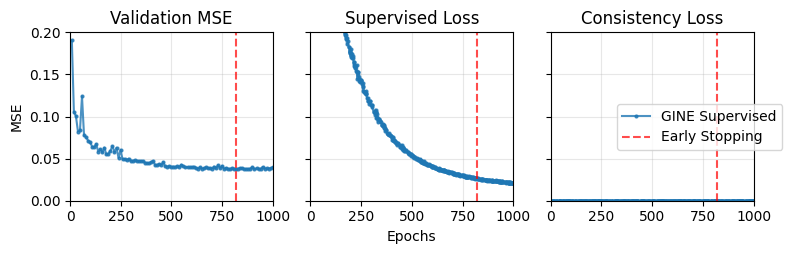

Unsupervised loss is just set to 0 for the supervised model.

## Training the semi-supervised model with mean teacher

For the semi-supervised model, we implement the Mean Teacher approach.

<img src="mean_teacher_diagram.png" width="600" style="background:white;">

The EMA update is defined as:
$$
\theta_t' = \alpha \theta_{t-1}' + (1-\alpha)\theta_t
$$

For unlabeled molecules $x_u$, the teacher generates a pseudo-label
$$
\hat{y}_u = f'(x_u),
$$
and the student is encouraged to match it through the consistency loss

The unsupervised loss is computed as the Mean Squared Error (MSE) between the predictions of the student model and the teacher model on the unlabeled data:
$$
L_{\text{cons}} = \|f(x_u)-\hat{y}_u\|^2.
$$
Where:
- $L_{\text{cons}}$ is the consistency loss
- $f(x_u)$ is the student model's prediction for the unlabeled data
- $\hat{y}_u$ is the teacher model's prediction for the unlabeled data
- $\|\cdot\|^2$ denotes the squared Euclidean error between predictions and target values.

Then the total loss is a weighted sum of the supervised and unsupervised losses:
$$
L = L_{sup} + \lambda(t) L_{cons}
$$

Where $\lambda(t)$ is a time-dependent weight that increases from 0 to 1 over 400 training epochs to gradually emphasize the unsupervised loss.

In [28]:
model_mt = GINE5(num_node_features=10, hidden_channels=64).to(device)
models_mt = [model_mt]

trainer_mt = SemiSupervisedEnsemble(
    supervised_criterion=MSELoss(),
    optimizer=make_optimizer,
    scheduler=make_scheduler,
    device=device,
    models=models_mt,
    logger=logger,
    datamodule=dm,
    unsupervised_weight=1.0, # Enable unsupervised loss
    use_mean_teacher=True, # Enable Mean Teacher
    ema_decay=0.999,
)

mt_epochs = 10 # For demonstration, we use a small number of epochs
validation_interval = 5

trainer_mt.train(total_epochs=mt_epochs, validation_interval=validation_interval)

mt_test_metrics = trainer_mt.test()
mt_test_metrics

Using device: cpu


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:09<01:28,  9.85s/it]

{'supervised_loss': np.float64(8.929176760882866), 'unsupervised_loss': np.float64(14.50103579534263), 'unsupervised_weight': 0.0025, 'epochs': 1}


 20%|██        | 2/10 [00:19<01:19,  9.90s/it]

{'supervised_loss': np.float64(1.366353921773957), 'unsupervised_loss': np.float64(25.281363975710985), 'unsupervised_weight': 0.005, 'epochs': 2}


 30%|███       | 3/10 [00:29<01:07,  9.70s/it]

{'supervised_loss': np.float64(0.778467900142437), 'unsupervised_loss': np.float64(24.656311360801137), 'unsupervised_weight': 0.0075, 'epochs': 3}


 40%|████      | 4/10 [00:39<01:00, 10.05s/it]

{'supervised_loss': np.float64(0.696257389900161), 'unsupervised_loss': np.float64(19.67279648199314), 'unsupervised_weight': 0.01, 'epochs': 4}


 50%|█████     | 5/10 [00:52<00:54, 10.86s/it, supervised_loss=0.636, unsupervised_loss=15.5, unsupervised_weight=0.0125, epochs=5, val_MSE=14.8]

{'supervised_loss': np.float64(0.6361838902642087), 'unsupervised_loss': np.float64(15.48584377474901), 'unsupervised_weight': 0.0125, 'epochs': 5, 'val_MSE': np.float64(14.790738619290865), 'best_val_MSE': np.float64(14.790738619290865), 'best_epoch': 5}


 60%|██████    | 6/10 [01:01<00:41, 10.25s/it, supervised_loss=0.636, unsupervised_loss=15.5, unsupervised_weight=0.0125, epochs=5, val_MSE=14.8]

{'supervised_loss': np.float64(0.5753918591795898), 'unsupervised_loss': np.float64(12.29712881693026), 'unsupervised_weight': 0.015, 'epochs': 6}


 70%|███████   | 7/10 [01:10<00:29,  9.80s/it, supervised_loss=0.636, unsupervised_loss=15.5, unsupervised_weight=0.0125, epochs=5, val_MSE=14.8]

{'supervised_loss': np.float64(0.5570686030678633), 'unsupervised_loss': np.float64(9.586038002153723), 'unsupervised_weight': 0.0175, 'epochs': 7}


 80%|████████  | 8/10 [01:18<00:19,  9.52s/it, supervised_loss=0.636, unsupervised_loss=15.5, unsupervised_weight=0.0125, epochs=5, val_MSE=14.8]

{'supervised_loss': np.float64(0.5206209551997301), 'unsupervised_loss': np.float64(7.656800182854257), 'unsupervised_weight': 0.02, 'epochs': 8}


 90%|█████████ | 9/10 [01:27<00:09,  9.29s/it, supervised_loss=0.636, unsupervised_loss=15.5, unsupervised_weight=0.0125, epochs=5, val_MSE=14.8]

{'supervised_loss': np.float64(0.5009186246046206), 'unsupervised_loss': np.float64(5.984300654108932), 'unsupervised_weight': 0.0225, 'epochs': 9}


100%|██████████| 10/10 [01:39<00:00,  9.90s/it, supervised_loss=0.474, unsupervised_loss=4.63, unsupervised_weight=0.025, epochs=10, val_MSE=4.41]


{'supervised_loss': np.float64(0.4744066381599845), 'unsupervised_loss': np.float64(4.634246378410153), 'unsupervised_weight': 0.025, 'epochs': 10, 'val_MSE': np.float64(4.4090271179492655), 'best_val_MSE': np.float64(4.4090271179492655), 'best_epoch': 10}
{'final_best_val_MSE': np.float64(4.4090271179492655), 'final_best_epoch': 10}


{'test_MSE': np.float64(4.4370978978963995)}

In the first part of training, the unsupervised (consistency) loss is high because the student and teacher produce inconsistent predictions on the unlabeled molecules. 

As training progresses, the teacher stabilizes due to the EMA update and the consistency loss decreases.

### Plot of the full run GCN (semi-supervised), GINE (supervised), GINE (semi-supervised)

The baseline model was trained the same way with semi-supervised learning

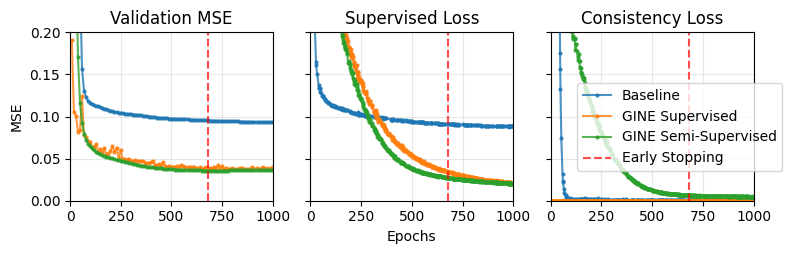

The final scores are included in the table below:

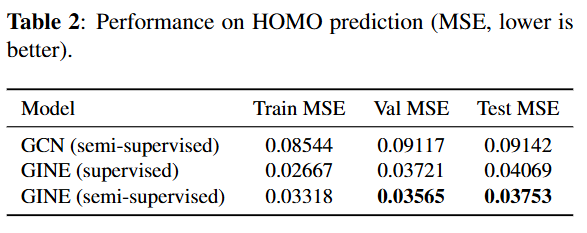